# 0. Install Dependencies

In [1]:
# !pip install tensorflow==2.3.0
# !pip install gym
# !pip install keras
# !pip install keras-rl2

# 1. Test Toy Environment with OpenAI Gym

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
from gym import spaces
import os
import copy
import math

In [3]:

def print_sent(sent):
    table = []
    sent = sent.split()
    for i in range(len(sent)):
        print(sent[i]+"(" + str(i) + ")", end = " ")
        
print_sent("In the old days , if one wants to tell some important news to another one , which lives far away , he needs to write letters and it wastes time .")


In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wants(7) to(8) tell(9) some(10) important(11) news(12) to(13) another(14) one(15) ,(16) which(17) lives(18) far(19) away(20) ,(21) he(22) needs(23) to(24) write(25) letters(26) and(27) it(28) wastes(29) time(30) .(31) 

In [4]:
# inpute one annotator correction in the fporm of a dictionary like -
# {'S': 'Genetic risk refers more to your chance of inheriting a disorder or disease .', 
# 'A_list': [{'indices': ['3', '4'], 'error_tag': 'Rloc-', 'correction': ''}]}

data1 = {'S': 'In old days , if one wants to tell some important news to another one , which lives far away , he needs to write letters and it wastes time .',
  'A_list': [{'indices': [1, 1], 'error_tag': 'ArtOrDet', 'correction': 'the'},
   {'indices': [6, 7], 'error_tag': 'Vt', 'correction': 'wanted'},
   {'indices': [8, 9], 'error_tag': 'Wci', 'correction': 'give'},
   {'indices': [13, 15], 'error_tag': 'Wci', 'correction': 'someone'},
   {'indices': [16, 17], 'error_tag': 'Ssub', 'correction': 'who'},
   {'indices': [17, 18], 'error_tag': 'Vt', 'correction': 'lived'},
   {'indices': [21, 23],
    'error_tag': 'Others',
    'correction': 'it was necessary'},
   {'indices': [28, 29], 'error_tag': 'Wci', 'correction': 'took'}],
  'G': 'In the old days , if one wanted to give some important news to someone , who lived far away , it was necessary to write letters and it wastes time took'}

def get_correct(data):
    sent = data["S"].split()
    shift = 0
    for action in data["A_list"]:
        index = action["indices"]
        # print_sent(" ".join(sent))
        # print(shift)
        # print(index[0]+shift, index[1]+shift)
        # print(sent)
        # print(sent[index[0]+shift], sent[index[1]+shift])
        sent = sent[:index[0]+shift] + action["correction"].split() + sent[index[1]+shift:]
        shift += len(action["correction"].split()) - (index[1] - index[0])
        # if index[0] == index[1]: shift += 1  
    return " ".join(sent)

In [5]:
# data1
get_correct(data1)

'In the old days , if one wanted to give some important news to someone , who lived far away , it was necessary to write letters and it took time .'

In [6]:
# string matching reward
def get_ied(instseq1, instseq2):
    m = len(instseq1)
    n = len(instseq2)
    if min(m,n) == 0: return 0
    cost_matrix = {}
    for i in range(m+1):
        for j in range(n+1):
            if min(i,j) == 0:
                cost_matrix[str(i)+'_'+str(j)] = max(i,j)
                continue
            cost = 1
            try:
                if instseq1[i-1] == (instseq2[j-1]):
                    cost = 0
            except:
                raise Exception('levenshtein calculation error')
            a = cost_matrix[str(i-1)+'_'+str(j)]+1
            b = cost_matrix[str(i)+'_'+str(j-1)]+1
            c = cost_matrix[str(i-1)+'_'+str(j-1)]+cost
            cost_matrix[str(i)+'_'+str(j)] = min(a, min(b,c))
    ed = float(cost_matrix[str(m)+'_'+str(n)])
    return 1 - (ed / max(m,n))

In [7]:
""" datapoint 301
[{'S': 'One of the diseases is sickle cell trait .',
  'A_list': [{'indices': [2, 3],
    'error_tag': 'ArtOrDet',
    'correction': 'these'}],
  'G': 'One of these diseases is sickle cell trait .'},
 {'S': 'One of the diseases is sickle cell trait .',
  'A_list': [{'indices': [1, 2], 'error_tag': 'Prep', 'correction': ''},
   {'indices': [2, 3], 'error_tag': 'ArtOrDet', 'correction': 'such'},
   {'indices': [3, 4], 'error_tag': 'Nn', 'correction': 'disease'}],
  'G': 'One  such disease is sickle cell trait .'}, ..........]
"""

" datapoint 301\n[{'S': 'One of the diseases is sickle cell trait .',\n  'A_list': [{'indices': [2, 3],\n    'error_tag': 'ArtOrDet',\n    'correction': 'these'}],\n  'G': 'One of these diseases is sickle cell trait .'},\n {'S': 'One of the diseases is sickle cell trait .',\n  'A_list': [{'indices': [1, 2], 'error_tag': 'Prep', 'correction': ''},\n   {'indices': [2, 3], 'error_tag': 'ArtOrDet', 'correction': 'such'},\n   {'indices': [3, 4], 'error_tag': 'Nn', 'correction': 'disease'}],\n  'G': 'One  such disease is sickle cell trait .'}, ..........]\n"

In [8]:
error_tags = ['ArtOrDet', 'Mec', 'Nn', 'Npos', 'Others', 'Pform', 'Pref', 'Prep', 'Rloc-', 'SVA', 'Sfrag', 'Smod', 
              'Srun', 'Ssub', 'Trans', 'Um', 'V0', 'Vform', 'Vm', 'Vt', 'WOadv', 'WOinc', 'Wci', 'Wform', 'Wtone']
feedback_template = {}
standard_string = "missing or incorrect"
feedback_template = {'ArtOrDet' : "Article", 
                  'Mec' : "Punctuation / capitalization / spelling",
                  'Nn' : "Noun number incorrect",
                  'Npos' : "Possesive Noun",
                  'Pform' : "Pronoun Form",
                  'Pref' : "Pronoun reference",
                  'Prep' : "Preposition",
                  'Rloc-' : "Local Redundency",
                  'SVA' : "Subject-verb-agreement",
                  'Sfrag' : "Sentence fragmant",
                  'Smod' : "Dangling Modifier",  #modifier could be misinterpreted as being associated with a word other than the one intended
                  'Srun' : "Runons / comma splice",  # fault is the use of a comma to join two independent clauses
                  'Ssub' : "Subordinate clause", # "I know that Bette is a dolphin" - here "that Bette is a dolphin" occurs as the complement of the verb "know" 
                  'Trans' : "Conjuctions",
                  'V0' : "Missing verb",
                  'Vform' : "Verb form",
                  'Vm' : "Verb modal",
                  'Vt' : "Verb tense",
                  'WOadv' : "Adverb/adjective position",
                  'Wci' : " Wrong collocation", # it went fair well -> fairly
                  'Wform' : "Word form"
                    }


# generating feedback with respect to annotator 1
def generate_feedback(datapoint):
    return feedback_template[datapoint[0]["error_tag"]]

In [9]:
file_path_10gec = "../Datasets/10gec_annotations/"
file = open(file_path_10gec + "A1.m2")

Vocab = set()
error_tags = set()
max_len = 0

for line in file.readlines():
    if line[0] == "S" and len(line[2:].strip())>0:
        Vocab.update(set(line[2:].strip().split()))
        max_len = max(max_len, len(line[2:].strip().split()))
    if line[0] == "A":
        words = line.split("|||")
        Vocab.update(set(words[2].split()))
        error_tags.update(set(words[1].split()))
Vocab = list(Vocab) + ["reflected"]
vocab_size = len(Vocab)

In [10]:
int((max_len+50)/10)*10

270

In [11]:
for e in sorted(list(error_tags)):
    print("'" + e + "'", end=", ")

'ArtOrDet', 'Mec', 'Nn', 'Npos', 'Others', 'Pform', 'Pref', 'Prep', 'Rloc-', 'SVA', 'Sfrag', 'Smod', 'Srun', 'Ssub', 'Trans', 'Um', 'V0', 'Vform', 'Vm', 'Vt', 'WOadv', 'WOinc', 'Wci', 'Wform', 'Wtone', 

In [38]:
# Extract ground truth correct sentences for grammatically incorect sentences
# Ex: S The opposite is also true .
#     A 5 6|||Mec|||:|||REQUIRED|||-NONE-|||0

corr_range = {}
dataset = {}
annotators = 10
for an in range(1, 11):
    file = "A" + str(an) + ".m2"
    file = open(file_path_10gec + file)
    current_S = ""
    current_A = []
    ex_ind = -1
    for line in file.readlines():
        if line[0] == "S":
            ex_ind += 1
            current_S = line[2:].strip()
        elif line[0] == "A":
            ans  = {}
            cells = line.strip().split("|||")
            ans["error_tag"] = cells[1]
            if ans["error_tag"] == "Um":
                continue
            ans["indices"] = [int(i) for i in cells[0].split()[1:]]  # A 5 6
            if ans["indices"][1] - ans["indices"][0] > 15:
                print(current_S, line)
            if (ans["indices"][1] - ans["indices"][0]) in corr_range: corr_range[(ans["indices"][1] - ans["indices"][0])] += 1
            else: corr_range[(ans["indices"][1] - ans["indices"][0])] = 1
            ans["correction"] = cells[2]
            current_A.append(ans)
        elif line.strip() == "":  # empty line
            annot = {"S" : current_S, "A_list" : current_A}
            dataset[ex_ind] = [annot] if an==1 else dataset[ex_ind] + [annot]
            dataset[ex_ind][an-1]["G"] = get_correct(dataset[ex_ind][an-1])
            current_S = ""
            current_A = []
        
data_size = len(dataset.keys())

It is a common scene that two people sitting next to each other seldom talk with each other but just look at their cellphone . A 0 24|||WOinc|||Two people sitting next to each other , seldom talking , but just looking at their cellphones is a common scene|||REQUIRED|||-NONE-|||0

As a result , they will lose eyes to contact and hands to express their feeling to people nearby them , which means they have lost the tools they need for face-to-face contact communicating . A 4 21|||Others|||their eyes and hands will be preoccupied|||REQUIRED|||-NONE-|||0

Based on the statistic report , the more of the writing skills will be reduced when the more time used in the social media sites . A 8 25|||WOinc|||time is spent on social media sites , the more writing skills will be reduced|||REQUIRED|||-NONE-|||0

Therefore , the decision to inform relatives of such genetic disorder will be dependent of the situation and backgroung of the affected family , with the liberty of choice given to them in mak

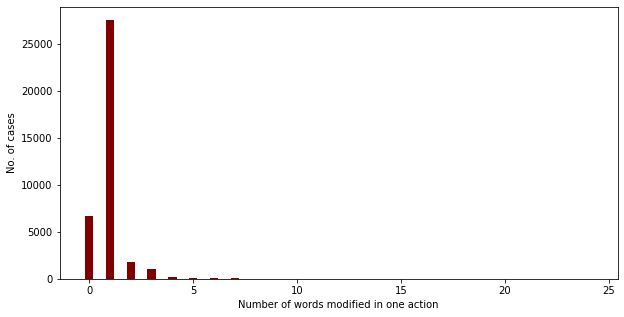

{1: 27533,
 0: 6664,
 2: 1804,
 3: 1040,
 4: 197,
 5: 99,
 8: 26,
 6: 58,
 7: 38,
 9: 15,
 10: 7,
 14: 2,
 11: 8,
 24: 1,
 17: 2,
 15: 2,
 13: 2,
 16: 1,
 12: 1}

In [40]:
# # dump the json in a file
# import json
# import os
# with open('./10gec_jsons/data.json', 'w') as fh:
#     json.dump(dataset, fh, indent=2)

import matplotlib.pyplot as plt
corr_range

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(list(corr_range.keys()), list(corr_range.values()), color ='maroon', width = 0.4)
plt.xlabel("Number of words modified in one action")
plt.ylabel("No. of cases")
# plt.title("Students enrolled in different courses")
plt.show()

corr_range

In [14]:
# vocab = ["", "I", "he", "she", "they", "am", "is", "are", "was", "were", "go", "going", "goes", "went", "market", 
#          "amusement-park", "to", "a", "an", "the"]
# vocab_size = len(vocab)
# max_len = 10
# Sample_sent = ["I is going to market.", "She am go to market.", "They are go to a amusement-park.", 
#                "He going to an market.", "I were going."]

In [15]:
def get_reward(sent, data_id, dataset):
    data = dataset[data_id]
    max_reward = 0
    for annotator in dataset[data_id]:
        G = annotator["G"]
        max_reward = max(max_reward, get_ied(sent.split(), G.split()))
    return max_reward          
    

In [16]:
s = 'People get certain diseases because of changes .'
get_reward(s, 3, dataset)

0.8888888888888888

In [17]:
def in_buffer(action_buffer, p1, p2):
    for act in action_buffer:
        if act[1] == p1 and act[2] == p2:
            return True
    return False


In [18]:
class OurCustomEnv(Env):

    def __init__(self):

        self.sent = ""
        self.data_id = -1
        self.data_state = ""
        self.gamma = 0.95
        self.annotator = 0
        self.feedback = ""

        self.reward = 0
        self.action_buffer = []
        self.sent_buff = []
        self.annotator_buff = []
        self.reward_buff = []
        # self.high =np.array([vocab_size] * max_len, dtype=np.int32)
        # self.low =np.array([0] * max_len, dtype=np.int32)
        
        # self.reward_unit = 10e-10
        #we create an observation space with predefined range
        self.observation_space = Box(low=np.array([vocab_size] * max_len, dtype=np.int32), high=np.array([0] * max_len, dtype=np.int32), dtype = np.float32)

        #similar to observation, we define action space 
        self.action_space = ["Replace", "Delete", "Add", "Undo"]
        
    
    def step(self, action, arg1 = [], string = ""):
        sent1 = self.sent.split()
        if action == "Undo":
            done, info = True, {}
            if len(self.sent_buff) < 2:
                self.feedback = "Error : There is no action to undo!!"
                self.action_buffer.append([action, "", ""])
                print("Reward = ", self.reward)
                print(self.feedback)
                print("Next state: ", self.sent)
                print_sent(self.sent)
                return self.sent, self.reward, done, info 

            self.action_buffer.append([action, "", ""])
            # restoring previous state
            self.sent = self.sent_buff[-2]
            del self.sent_buff[-1]
            self.annotator =  self.annotator_buff[-2]
            del self.annotator_buff[-1]
            self.reward = self.reward_buff[-2]
            del self.reward_buff[-1]
            self.feedback = "Reverted back to old state"
            print("Reward = ", self.reward)
            print(self.feedback)
            print("Next state: ", self.sent)
            print_sent(self.sent)
            return self.sent, self.reward, done, info 

        phrase1, phrase2 = " ".join(self.sent.split()[arg1[0]:arg1[1]]), string
        # print("act: ", phrase1, phrase2)

        self.action_buffer.append([action, phrase1, phrase2])

        if action == "Delete":
            self.sent = " ".join(sent1[:arg1[0]] + sent1[arg1[1]:])
        
        elif action == "Add":
            self.sent = " ".join(sent1[:arg1[0]] + [string] + sent1[arg1[1]:])
            
        elif action == "Replace":
            self.sent = " ".join(sent1[:arg1[0]] + [string] + sent1[arg1[1]:])
        
        # new_reward = get_reward(self.sent, self.data_id, dataset)
        # if new_reward < self.reward:
        max_reward = 0
        for i in range(len(self.data_state)):
            annot = self.data_state[i]
            curr_reward = get_ied(self.sent.split(), annot["G"].split())
            if max_reward < curr_reward:
                max_reward = curr_reward
                self.annotator = i

        action_seq = self.data_state[self.annotator]["A_list"]
        self.feedback == ""
        if max_reward == 1:
            self.feedback = "Feedback: The sentence is grammatically correct! "
        else:
            if max_reward > self.reward:
                self.feedback = "Feedback: Yes, we are getting closer to the correct sentence! "
            else:
                self.feedback = "Feedback: You might want to recheck your last action! "
            for i in range(len(action_seq)):
                act = action_seq[i]
                p1 = " ".join(self.data_state[self.annotator]["S"].split()[act["indices"][0] : act["indices"][1]])
                p2 = self.data_state[self.annotator]["A_list"][i]["correction"]
            
                # # latest performed action matched 
                # if p1 == phrase1 and p2 == phrase2:

                # found action not performed yet
                if not in_buffer(self.action_buffer, p1, p2):
                    err = self.data_state[self.annotator]["A_list"][i]["error_tag"]
                    # TO DO: add level of feedback based on failed attempts
                    if err in feedback_template:
                        self.feedback += "Hint: There is an error in the " + feedback_template[err]
                    else:
                        self.feedback += "Hint: Action doesn't seem to be correct."
                    break
            # all actions done but still incorrect
            if "Hint" not in self.feedback:
                self.feedback += "Hint: You have done some unnecessary changes in the sentence. Undo the incorrect action(s)."

        # self.reward = math.pow(self.gamma, len(self.action_buffer)-1)*max_reward
        self.reward = max_reward

        print("Reward = ", self.reward)
        print(self.feedback)
        print("Next state: ", self.sent)
        print_sent(self.sent)
        done = True                            #Condition for completion of episode
        info = {}        

        self.sent_buff.append(self.sent)
        self.annotator_buff.append(self.annotator)
        self.reward_buff.append(self.reward)

        return self.sent, self.reward, done, info 

    def reset(self):
        #self.data_id = random.randint(0, data_size)-1
        self.data_id = 1262
        # 604
        print("data id = ",self.data_id)
        print("reward = ", self.reward)
        self.sent = copy.deepcopy(dataset[self.data_id ][0]["S"])
        self.data_state = copy.deepcopy(dataset[self.data_id ])
        self.action_buffer = []
        self.sent_buff = [self.sent]
        self.annotator_buff = [0]
        self.reward_buff = [0]
        # self.reward_unit = 1/max(len(dataset[self.data_id ][0]["A_list"]), 1)
        return self.sent
    
def act(action, ind1=[], string=""):
    # if action == "Delete":
    #     return env.step("Delete", ind1)
    # else:
    return env.step(action, ind1, string)    


In [19]:
env = OurCustomEnv()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [20]:
state = env.reset()
state

data id =  1262
reward =  0


'In old days , if one wants to tell some important news to another one , which lives far away , he needs to write letters and it wastes time .'

In [21]:
print_sent(state)

In(0) old(1) days(2) ,(3) if(4) one(5) wants(6) to(7) tell(8) some(9) important(10) news(11) to(12) another(13) one(14) ,(15) which(16) lives(17) far(18) away(19) ,(20) he(21) needs(22) to(23) write(24) letters(25) and(26) it(27) wastes(28) time(29) .(30) 

In [22]:
act1 = act("Add", [1,1], "the")
print(act1[1])

Reward =  0.8125
Feedback: Yes, we are getting closer to the correct sentence! Hint: There is an error in the Verb tense
Next state:  In the old days , if one wants to tell some important news to another one , which lives far away , he needs to write letters and it wastes time .
In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wants(7) to(8) tell(9) some(10) important(11) news(12) to(13) another(14) one(15) ,(16) which(17) lives(18) far(19) away(20) ,(21) he(22) needs(23) to(24) write(25) letters(26) and(27) it(28) wastes(29) time(30) .(31) 0.8125


In [23]:
# act1 = act("Undo")
act1 = act("Replace", [14, 16], "someone")
print(act1[1])
# env.annotator

Reward =  0.8064516129032258
Feedback: You might want to recheck your last action! Hint: There is an error in the Verb tense
Next state:  In the old days , if one wants to tell some important news to someone , which lives far away , he needs to write letters and it wastes time .
In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wants(7) to(8) tell(9) some(10) important(11) news(12) to(13) someone(14) ,(15) which(16) lives(17) far(18) away(19) ,(20) he(21) needs(22) to(23) write(24) letters(25) and(26) it(27) wastes(28) time(29) .(30) 0.8064516129032258


In [24]:
act1 = act("Replace", [7,8], "wanted")
print(act1[1])

Reward =  0.8387096774193549
Feedback: Yes, we are getting closer to the correct sentence! Hint: There is an error in the Local Redundency
Next state:  In the old days , if one wanted to tell some important news to someone , which lives far away , he needs to write letters and it wastes time .
In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wanted(7) to(8) tell(9) some(10) important(11) news(12) to(13) someone(14) ,(15) which(16) lives(17) far(18) away(19) ,(20) he(21) needs(22) to(23) write(24) letters(25) and(26) it(27) wastes(28) time(29) .(30) 0.8387096774193549


In [25]:
act1 = act("Replace", [14,16], "someone")
print(act1[1])
# 'G': 'In the old days , if one wanted to give some important news to someone , who lived far away , it was necessary to 
# write letters and it wastes time took'},

Reward =  0.8666666666666667
Feedback: Yes, we are getting closer to the correct sentence! Hint: There is an error in the Local Redundency
Next state:  In the old days , if one wanted to tell some important news to someone which lives far away , he needs to write letters and it wastes time .
In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wanted(7) to(8) tell(9) some(10) important(11) news(12) to(13) someone(14) which(15) lives(16) far(17) away(18) ,(19) he(20) needs(21) to(22) write(23) letters(24) and(25) it(26) wastes(27) time(28) .(29) 0.8666666666666667


In [26]:
act1 = act("Replace", [9,10], "give")
print(act1[1])

Reward =  0.8333333333333334
Feedback: You might want to recheck your last action! Hint: There is an error in the Local Redundency
Next state:  In the old days , if one wanted to give some important news to someone which lives far away , he needs to write letters and it wastes time .
In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wanted(7) to(8) give(9) some(10) important(11) news(12) to(13) someone(14) which(15) lives(16) far(17) away(18) ,(19) he(20) needs(21) to(22) write(23) letters(24) and(25) it(26) wastes(27) time(28) .(29) 0.8333333333333334


In [27]:
act1 = act("Replace", [16,18], "who lived")
print(act1[1])

Reward =  0.8125
Feedback: You might want to recheck your last action! Hint: There is an error in the Subordinate clause
Next state:  In the old days , if one wanted to give some important news to someone which who lived away , he needs to write letters and it wastes time .
In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wanted(7) to(8) give(9) some(10) important(11) news(12) to(13) someone(14) which(15) who(16) lived(17) away(18) ,(19) he(20) needs(21) to(22) write(23) letters(24) and(25) it(26) wastes(27) time(28) .(29) 0.8125


In [28]:
act1 = act("Replace", [21,23], "it was necessary")
print(act1[1])

Reward =  0.84375
Feedback: Yes, we are getting closer to the correct sentence! Hint: There is an error in the Subordinate clause
Next state:  In the old days , if one wanted to give some important news to someone which who lived away , he it was necessary write letters and it wastes time .
In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wanted(7) to(8) give(9) some(10) important(11) news(12) to(13) someone(14) which(15) who(16) lived(17) away(18) ,(19) he(20) it(21) was(22) necessary(23) write(24) letters(25) and(26) it(27) wastes(28) time(29) .(30) 0.84375


In [29]:
act1 = act("Replace", [29,30], "took")
print(act1[1])

Reward =  0.8125
Feedback: You might want to recheck your last action! Hint: There is an error in the Subordinate clause
Next state:  In the old days , if one wanted to give some important news to someone which who lived away , he it was necessary write letters and it wastes took .
In(0) the(1) old(2) days(3) ,(4) if(5) one(6) wanted(7) to(8) give(9) some(10) important(11) news(12) to(13) someone(14) which(15) who(16) lived(17) away(18) ,(19) he(20) it(21) was(22) necessary(23) write(24) letters(25) and(26) it(27) wastes(28) took(29) .(30) 0.8125


In [43]:
# # env.annotator
# for i in range(0, 1312):
#     for 
#     print(i, dataset[i][0]["A_list"])

dataset[1262][8]



{'S': 'In old days , if one wants to tell some important news to another one , which lives far away , he needs to write letters and it wastes time .',
 'A_list': [{'error_tag': 'ArtOrDet', 'indices': [1, 1], 'correction': 'the'},
  {'error_tag': 'Vt', 'indices': [6, 7], 'correction': 'wanted'},
  {'error_tag': 'Pref', 'indices': [14, 15], 'correction': 'person'},
  {'error_tag': 'Ssub', 'indices': [16, 17], 'correction': 'who'},
  {'error_tag': 'Pref', 'indices': [21, 22], 'correction': 'they'},
  {'error_tag': 'Vt', 'indices': [22, 23], 'correction': 'needed'},
  {'error_tag': 'Vt', 'indices': [28, 29], 'correction': 'wasted'}],
 'G': 'In the old days , if one wanted to tell some important news to another person , who lives far away , they needed to write letters and it wasted time .'}

In [ ]:
len(dataset)

1312